# Exercise 2: Neural Networks


## Environment
- Platform: Google Colab
- Set a global random seed for reproducibility (e.g., np.random.seed(42)).


## Read the following instructions carefully:

1. **Follow the Guide:** This Jupyter Notebook contains all the step-by-step instructions needed for this exercise. Fill in the missing parts wherever marked with TODO.
2. **Vectorization:** Write efficient vectorized code. Avoid for-loops unless explicitly allowed. Inefficient code that acts as a bottleneck will be penalized.
3. **Correctness & Testing:** You are responsible for the correctness of your code. Add as many test cells as you see fit to verify your logic. (Note: your tests will not be graded).
4. **Immutable Functions:** Do not change the signatures or names of the functions we provided.
5. **Allowed Libraries:** You are allowed to use functions and methods from the Python Standard Library and numpy only. Any other imports (such as torch, sklearn, etc.) are strictly forbidden.
6. **Runtime Efficiency:** Your code must run within a reasonable time. We will not grade notebooks that take an excessive amount of time to execute due to inefficient implementation.
7. **Qualitative Answers:** Answers to qualitative questions should be written in markdown cells (with $\LaTeX$ support).


## Submission guidelines:
- What to submit: A single notebook file named ID_ex2.ipynb (e.g., 123456789_ex2.ipynb).
- Your submitted notebook should **run without problems**.
- Please submit your **executed** (fully run) notebook, including all outputs (plots, printed results, etc.). Make sure that all cells have been run in order from top to bottom before submission.

## Academic integrity

You may discuss ideas, but all submitted code must be your own. Cite any external snippets.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import sys
import urllib.request
import tarfile
import zipfile
from random import randrange
from functools import partial
import itertools
import time

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data preprocessing
In this section, we will use the same code as in Homework 1.


## Data download and processing Helper Code

In [ ]:
def download_and_extract(url, download_dir):
    """
    Download and extract the CIFAR-10 dataset if it doesn't already exist.

    Parameters
    ----------
    url : str
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    download_dir : str
        Directory where the downloaded file will be saved and extracted.
        Example: "data/CIFAR-10/"

    Returns
    -------
    None
    """

    # Determine filename and full path where the file will be saved
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if dataset is already downloaded (and extracted)
    if not os.path.exists(file_path):
       # Create the directory if it doesn’t exist
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the dataset
        print("Downloading, This might take several minutes.")
        last_update_time = time.time()
        file_path, _ = urllib.request.urlretrieve(url=url, filename=file_path)

        print()
        print("Download finished. Extracting files.")

        # Extract the dataset
        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done. Dataset is ready!")
    else:
        print("Dataset already downloaded and unpacked.")
        print("If something seems wrong, delete the folder and re-run.")


def load_CIFAR_batch(filename):
    ''' Load a single batch of the CIFAR-10 dataset.'''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']

        # Reshape and transpose: original shape (10000, 3072)
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y


def load(ROOT):
    ''' Load all training and test batches of CIFAR-10.'''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

## Data Download

In this section, we will download and extract the **CIFAR-10** dataset if it is not already available locally.

- The dataset will be saved under: `datasets/cifar10/`
- If it’s already there, the script will **skip downloading**.
- This process may take a few minutes the first time you run it.

In [ ]:
# ---------------------------------------------------------------------
# Data Download (Run once)
# ---------------------------------------------------------------------
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/'
download_and_extract(URL, PATH)

Downloading, This might take several minutes.

Download finished. Extracting files.


/tmp/ipython-input-787463260.py:43: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)


Done. Dataset is ready!


In [ ]:
# ---------------------------------------------------------------------
# Load the full CIFAR-10 dataset from local path
# ---------------------------------------------------------------------
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load(CIFAR10_PATH)  # load the entire data

## Data Preprocessing

**Notice that we are leaving behind the bias trick in this exercise.**

In [ ]:
# ---------------------------------------------------------------------
# Filter the dataset to include only the target classes
# ------------------------------------------/---------------------------
TARGET_CLASSES = [2, 3, 4]
classes = ['bird', 'cat', 'deer']
train_mask = np.isin(y_train, TARGET_CLASSES)
test_mask  = np.isin(y_test,  TARGET_CLASSES)

X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_test  = X_test[test_mask]
y_test  = y_test[test_mask]

# ---------------------------------------------------------------------
# Relabel to {0,1,2} so predictions match labels
# ---------------------------------------------------------------------
label_map = {orig: i for i, orig in enumerate(TARGET_CLASSES)}
y_train = np.vectorize(label_map.get)(y_train)
y_test  = np.vectorize(label_map.get)(y_test)

# ------------------------------------------------------------
# Define sizes for training / validation / test splits
# ------------------------------------------------------------
num_training   = 10000
num_validation = 1000
num_testing    = 1000

# ---------------------------------------------------------------------
# Create subset
# ---------------------------------------------------------------------

# Training subset
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Validation subset
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]

# Test subset
mask = range(num_validation, num_validation + num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# ---------------------------------------------------------------------
# Convert to float64 (optional)
# ---------------------------------------------------------------------
X_train = X_train.astype(np.float64)
X_val   = X_val.astype(np.float64)
X_test  = X_test.astype(np.float64)

print("Shapes ->",
      "X_train", X_train.shape, "y_train", y_train.shape,
      "X_val",   X_val.shape,   "y_val",   y_val.shape,
      "X_test",  X_test.shape,  "y_test",  y_test.shape)

Shapes -> X_train (10000, 32, 32, 3) y_train (10000,) X_val (1000, 32, 32, 3) y_val (1000,) X_test (1000, 32, 32, 3) y_test (1000,)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_batch(X, y, n=1000):
    "Randomly select a batch of samples from the dataset."
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return images, labels


def make_random_grid(x, y, n=4, convert_to_image=True, random_flag=True):
    "Create a grid of random images (or flattened vectors) from dataset."
    if random_flag:
        rand_items = np.random.randint(0, x.shape[0], size=n)
    else:
        rand_items = np.arange(0, x.shape[0])
    images = x[rand_items]
    labels = y[rand_items]
    if convert_to_image:
        grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int64) for i in images]))
    else:
        grid = np.hstack(np.array([np.asarray(i, dtype=np.int64) for i in images]))
    print('\t'.join('%9s' % classes[labels[j]] for j in range(n)))
    return grid


def vec_2_img(x):
    """ Convert a flattened CIFAR-10 image vector back to a (32, 32, 3) RGB image.
    Removes bias term if present."""
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

     deer	     bird	     deer	     bird


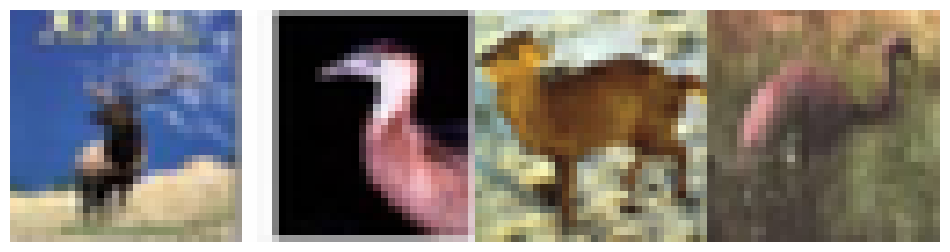

In [ ]:
# quick sanity check preview
X_batch, y_batch = get_batch(X_test, y_test, 100)
plt.imshow(make_random_grid(X_batch, y_batch, n=4, convert_to_image=False))
plt.axis("off")
plt.show()

# Loss

## Cross-entropy


Complete the function `softmax_loss` using vectorized code. This function takes as input `scores`, labels `y` and outputs the calculated loss as a single number and the gradients with respect to scores. **(5 Points)**

In [ ]:
def softmax_loss(scores, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - scores: scores of shape (N, C) where scores[i, c] is the score for class c on input X[i].
    - y: Vector of labels

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to scores
    - REMEMBER TO ALWAYS DIVIDE THE LOSS BY THE BATCH SIZE (N)
    """
    N = scores.shape[0]

    # Stability trick

    max_scores = np.max(scores, axis=1, keepdims=True)

    exp_scores = np.exp(scores - max_scores)

    sum_exp_scores = np.sum(exp_scores, axis=1, keepdims=True)

    probs = exp_scores / sum_exp_scores

    log_sum_exp = np.log(sum_exp_scores) + max_scores

    Y = np.zeros_like(scores)
    Y[np.arange(N), y] = 1

    true_scores = scores[np.arange(N), y]

    loss_per_instance = log_sum_exp.flatten() - true_scores

    loss = np.mean(loss_per_instance)

    dx = probs - Y
    dx /= N

    return loss, dx

In [ ]:
# some tests
np.random.seed(42)

num_instances = 5
num_classes = 3

y = np.random.randint(num_classes, size=num_instances)
scores = np.random.randn(num_instances * num_classes).reshape(num_instances, num_classes)
loss, dx = softmax_loss(scores, y)


correct_grad = np.array([[ 0.0062,  0.1751, -0.1813],
         [-0.1463,  0.0561,  0.0901],
         [ 0.0404,  0.0771, -0.1174],
         [ 0.0223,  0.0855, -0.1078],
         [-0.1935,  0.1358,  0.0578]])
correct_loss = 1.7544
print(dx)
print(loss)

assert np.isclose(dx.round(4), correct_grad, rtol=1e-3).all()
assert np.isclose(loss.round(4), correct_loss, rtol=1e-3).all()

[[ 0.00620775  0.17508363 -0.18129138]
 [-0.14625024  0.05614496  0.09010528]
 [ 0.04036297  0.07706864 -0.11743161]
 [ 0.02228183  0.08546912 -0.10775095]
 [-0.19352258  0.13575747  0.0577651 ]]
1.7543643062726173


## L2 Regularization

Regularization is a very important technique in machine learning to prevent overfitting. Mathematically speaking, it adds a regularization term to the loss to penalize larger weights.
$$
Loss = Loss + \lambda  \cdot \frac{1}{2} \cdot \sum_{i=0}^k w_k^2
$$

Implement the L2 regularization part of the loss in the next cell: **(10 Points)**

In [ ]:
def l2_regulariztion_loss(W, reg=0):
    """
    L2 regulariztion loss function, vectorized version.
    - W: a layer's weights.
    - reg: (float) regularization strength
    """
    loss = 0.0
    dW = np.zeros_like(W)
    #############################################################################
    # TODO: Compute the L2 reulariztion loss and its gradient using no
    # explicit loops.                                                           #
    # Store the loss in loss and the gradient in dW.                            #
    #############################################################################
    loss = loss + 0.5 * reg * np.sum(W**2)
    dW = dW + reg*W



    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
    return loss, dW

# Neural Network

The implementation of linear regression was (hopefully) simple yet not very modular since the layer, loss and gradient were calculated as a single monolithic function. This would become impractical as we move towards bigger models. As a warmup towards `PyTorch`, we want to build networks using a more modular design so that we can implement different layer types in isolation and easily integrate them together into models with different architectures.

This logic of isolation & integration is at the heart of all popular deep learning frameworks, and is based on two methods each layer holds - a forward and backward pass.
- The forward function will receive inputs, weights and other parameters and will return both an output and a cache object storing data needed for the backward pass.
- The backward pass will receive upstream derivatives and the cache, and will return gradients with respect to the inputs and weights.

By implementing several types of layers this way, we will be able to easily combine them to build classifiers with different architectures with relative ease.

The Task: In the following cells, we will implement a Neural Network to obtain better results on the CIFAR-10 dataset. We will train this network using Softmax loss, L2 regularization, and ReLU non-linearity.


### Fully Connected Layer: Forward Pass.

Implement the function `fc_forward`. **(5 Points)**

In [ ]:
def fc_forward(X, W, b):
    """
    Computes the forward pass for an fully connected layer.
    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.
    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - W: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    #############################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You     #
    # will need to reshape the input into rows.                                 #
    #############################################################################
    N = X.shape[0]

    X_col = X.reshape(N,-1)

    out = X_col.dot(W) + b


    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = (X.copy(), W.copy(), b.copy())
    return out, cache

In [ ]:
np.random.seed(42)

num_instances = 5
input_shape = (11, 7, 3)
output_shape = 4

X = np.random.randn(num_instances * np.prod(input_shape)).reshape(num_instances, *input_shape)
W = np.random.randn(np.prod(input_shape) * output_shape).reshape(np.prod(input_shape), output_shape)
b = np.random.randn(output_shape)

out, _ = fc_forward(X, W, b)

#print(X[0])
#print(X.shape)
#print(W.shape)
#testing = X[0].flatten()
#print(X.shape)
#print(testing.shape)
#print(b.shape)
correct_out = np.array([[16.77132953,  1.43667172, -15.60205534,   7.15789287],
                        [ -8.5994206,  7.59104298,  10.92160126,  17.19394331],
                        [ 4.77874003,  2.25606192,  -6.10944859,  14.76954561],
                        [21.21222953, 17.82329258,   4.53431782,  -9.88327913],
                        [18.83041801, -2.55273817,  14.08484003,  -3.99196171]])

assert np.isclose(out, correct_out, rtol=1e-8).all()

### Fully Connected Layer: Backward Pass

Implement the function `fc_backward` **(5 Points)**

In [ ]:
def fc_backward(dout, cache):
    """
    Computes the backward pass for an fully connected layer.
    Try the link in the exercise intructions for more details.

    Inputs:
    - dout: Upstream derivatives
    - cache: Tuple of:
      - X: Input data
      - W: Weights
      - b: Biases

    Returns a tuple of:
    - dx: Gradient with respect to X
    - dw: Gradient with respect to W
    - db: Gradient with respect to b
    """
    x, w, b = cache
    dx, dw, db = 0, 0, 0
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    N = dout.shape[0]
    x_reshaped = x.reshape(N, -1)

    dw = x_reshaped.T.dot(dout)

    db = np.sum(dout, axis=0)

    dx_flat = dout.dot(w.T)

    dx = dx_flat.reshape(x.shape)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

In [ ]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

In [ ]:
np.random.seed(42)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_forward(x, w, b)[0], b, dout)

out, cache = fc_forward(x,w,b)
dx, dw, db = fc_backward(dout, cache)

assert np.isclose(dw, dw_num, rtol=1e-8).all() # simple test
assert np.isclose(dx, dx_num, rtol=1e-8).all() # simple test
assert np.isclose(db, db_num, rtol=1e-8).all() # simple test

### ReLU: Forward Pass

Implement the function `relu_forward`. **(5 Points)**

In [ ]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    #############################################################################
    # TODO: Implement the ReLU forward pass.                                    #
    #############################################################################
    N = x.shape[0]
    x_reshaped = x.reshape(N,-1)
    out_flat = np.maximum(0, x_reshaped)
    out = out_flat.reshape(x.shape)

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = x.copy()
    return out, cache

In [ ]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)
out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

assert np.isclose(out, correct_out, rtol=1e-8).all() # simple test

### ReLU: Backward Pass

Implement the function `relu_backward`. **(5 Points)**

In [ ]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    dx = np.array(dout, copy=True)
    dx[x <= 0] = 0
    return dx

In [ ]:
np.random.seed(42)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)
dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)
xx, cache = relu_forward(x)
dx = relu_backward(dout, cache)

assert np.isclose(dx, dx_num, rtol=1e-8).all()  # simple test

### Combined Layer
Next combine the fully connected and relu forward\backward functions togther using the functions in the following cell.
Remember to use functions you already implemented.
**(5 Points)**

In [ ]:
def fc_relu_forward(X, W, b):
    """
    Forward pass for a fully connected layer followed by a ReLU.

    Inputs:
    - X: Input to the fc layer
    - W, b: Weights for the fc layer

    Returns:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    #############################################################################
    # TODO: Implement the function.                                             #
    #############################################################################
    fc_out, fc_cache = fc_forward(X, W, b)
    relu_out, relu_cache = relu_forward(fc_out)
    out = relu_out
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = (fc_cache, relu_cache)
    return out, cache


def fc_relu_backward(dout, cache):
    """
    Backward pass for a fully connected layer followed by a ReLU
    Inputs:
    - dout: upstream derivatives
    - cache: parameters calculated during the forward pass

    Returns:
    - dX: derivative w.r.t X
    - dW: derivative w.r.t W
    - db: derivative w.r.t b
    """
    fc_cache, relu_cache = cache
    #############################################################################
    # TODO: Implement the function.                                             #
    #############################################################################
    relu_dx = relu_backward(dout, relu_cache)
    dx, dw, db = fc_backward(relu_dx, fc_cache)

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx, dw, db

You can check your results in the next cell:

In [ ]:
np.random.seed(42)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_relu_forward(x, w, b)[0], b, dout)

out, cache = fc_relu_forward(x,w,b)
dx, dw, db = fc_relu_backward(dout, cache)

assert np.isclose(dw, dw_num, rtol=1e-8).all() # simple test
assert np.isclose(dx, dx_num, rtol=1e-8).all() # simple test
assert np.isclose(db, db_num, rtol=1e-8).all() # simple test

# Building the Network



Complete the class `ThreeLayerNet`. **(25 Points)**

In [ ]:
class ThreeLayerNet(object):
    """
    A three-layer fully-connected neural network. This network has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    In our case, we use the same hidden dimension across all hidden layers.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. In other words, the network has the following architecture:

    input - fc layer - ReLU - fc layer - ReLu - fc layer - softmax

    The outputs of the third fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-2):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, H)
        b2: Second layer biases; has shape (H,)
        W3: Second layer weights; has shape (H, C)
        b3: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in each of the hidden layers.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

    def step(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a three layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization coefficient.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']

        # Compute the forward pass
        scores = None
        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################
        out_1, cache_1 = fc_relu_forward(X, W1, b1)
        out_2, cache_2 =fc_relu_forward(out_1, W2, b2)
        scores, cache_3 = fc_forward(out_2, W3, b3)



        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss, scores_grad = softmax_loss(scores, y)
        w1_loss, dw1_reg = l2_regulariztion_loss(W1, reg)
        w2_loss, dw2_reg= l2_regulariztion_loss(W2, reg)
        w3_loss, dw3_reg = l2_regulariztion_loss(W3, reg)
        loss = loss + w1_loss + w2_loss + w3_loss
        ###############################################################################
        # After you finished the forward pass, compute the loss. This should include  #
        # both the data loss and L2 regularization for W1, W2, W3. Store the result   #
        # in the variable loss, which should be a scalar. Use the softmax_loss        #
        # and l2_regulariztion_loss functions you implemented.                        #
        ###############################################################################







        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] = dW1 + dW1_reg, it stores the gradient on W1, including      #
        # regularization. It should be a matrix of the same size.                   #
        #############################################################################
        # for now IGNORE the regulissation
        dx3, dw3, db3 = fc_backward(scores_grad, cache_3)
        dx2, dw2, db2 = fc_relu_backward(dx3, cache_2)
        dx1, dw1, db1 = fc_relu_backward(dx2, cache_1)

        grads['W1'] = dw1 + dw1_reg
        grads['W2'] = dw2 + dw2_reg
        grads['W3'] = dw3 + dw3_reg
        grads['b1'] = db1
        grads['b2'] = db2
        grads['b3'] = db3
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training label.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None
            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            batch_id = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[batch_id]
            y_batch = y[batch_id]
            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            # Compute loss and gradients using the current minibatch
            loss, grads = self.step(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)
            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            self.params['W1'] = self.params['W1'] - learning_rate*grads['W1']
            self.params['b1'] = self.params['b1'] - learning_rate*grads['b1']
            self.params['W2'] = self.params['W2'] - learning_rate*grads['W2']
            self.params['b2'] = self.params['b2'] - learning_rate*grads['b2']
            self.params['W3'] = self.params['W3'] - learning_rate*grads['W3']
            self.params['b3'] = self.params['b3'] - learning_rate*grads['b3']


            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            if verbose and (it+1) % 100 == 0:
                print ('iteration %d / %d: loss %f' % (it+1, num_iters, loss))

            # Every epoch, check train and val accuracy.
            if it % iterations_per_epoch == 0:
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this three-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: data points to classify.

        Returns:
        - y_pred: predicted labels
        """
        y_pred = None
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']

        ###########################################################################
        # TODO: Implement this function                                           #
        ###########################################################################
        out_1, _ = fc_relu_forward(X, W1, b1)
        out_2, _ =fc_relu_forward(out_1, W2, b2)
        scores, _ = fc_forward(out_2, W3, b3)

        y_pred = np.argmax(scores, axis=1)

        ###########################################################################
        #                              END OF YOUR CODE                           #
        ###########################################################################
        return y_pred

In [ ]:
input_size = 32 * 32 * 3
hidden_size = 128
num_classes = 3
model = ThreeLayerNet(input_size, hidden_size, num_classes)

In [ ]:
%%time
stats = model.train(X_train, y_train, X_val, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=1e-3, reg=0, verbose=True)

iteration 100 / 1500: loss 0.952158
iteration 200 / 1500: loss 0.914081
iteration 300 / 1500: loss 0.915170
iteration 400 / 1500: loss 0.882715
iteration 500 / 1500: loss 0.874077
iteration 600 / 1500: loss 0.877913
iteration 700 / 1500: loss 0.809114
iteration 800 / 1500: loss 0.829799
iteration 900 / 1500: loss 0.806774
iteration 1000 / 1500: loss 0.838096
iteration 1100 / 1500: loss 0.832759
iteration 1200 / 1500: loss 0.866482
iteration 1300 / 1500: loss 0.836913
iteration 1400 / 1500: loss 0.786428
iteration 1500 / 1500: loss 0.852496
CPU times: user 2min 6s, sys: 57.7 ms, total: 2min 6s
Wall time: 1min 18s


In [ ]:
%%time
val_acc = (model.predict(X_val) == y_val).mean()
print ('Validation accuracy: ', val_acc)

Validation accuracy:  0.567
CPU times: user 122 ms, sys: 10.9 ms, total: 133 ms
Wall time: 69.9 ms


In [ ]:
%%time
train_acc = (model.predict(X_train) == y_train).mean()
print ('Training accuracy: ', train_acc)

Training accuracy:  0.6167
CPU times: user 1.07 s, sys: 123 ms, total: 1.2 s
Wall time: 678 ms


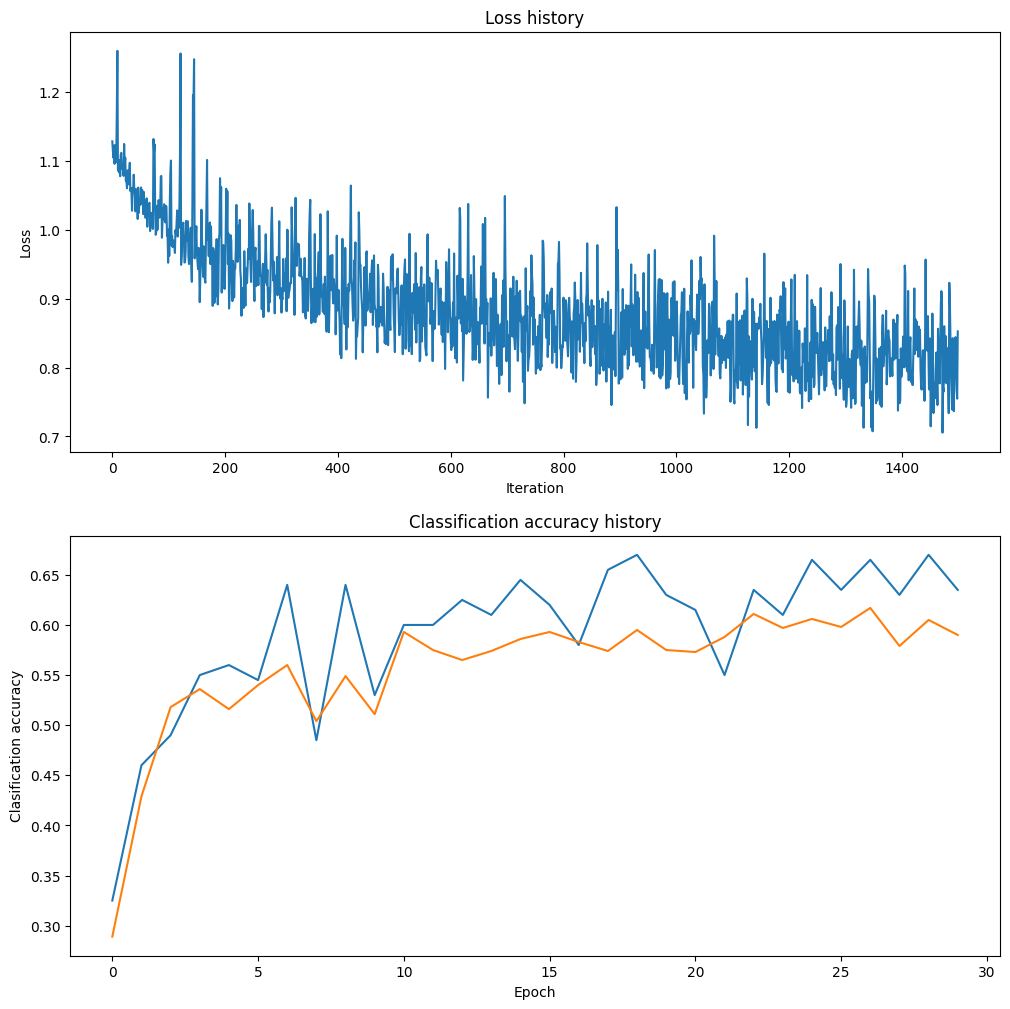

In [ ]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

## Hyperparameter Optimization
Use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, hidden_size, regularization)` to tuples of the form `(training_accuracy, validation_accuracy)`. You should evaluate the best model on the testing dataset and print out the training, validation and testing accuracies for each of the models and provide a clear visualization. Highlight the best model w.r.t the testing accuracy. **(10 Points)**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def hpo_histogram(results_dict):
    """
    Creates two stacked bar charts (one above the other) showing Training
    and Validation Accuracy, with parameter labels visible on both X-axes.
    """
    data = []
    for hparams, accuracy in results_dict.items():
        label = f"LR={hparams[0]:.0e}, HS={hparams[1]}, Reg={hparams[2]:.0e}"
        data.append({
            'Model Label': label,
            'Validation Accuracy': accuracy[1],
            'Training Accuracy': accuracy[0]
        })

    df = pd.DataFrame(data)
    # Sort by Validation Accuracy
    df = df.sort_values(by='Validation Accuracy', ascending=False).reset_index(drop=True)

    N = len(df)

    fig, axes = plt.subplots(2, 1, figsize=(max(15, N * 0.5), 14))

    # Formatting parameters
    rotation_angle = 60
    label_size = 12

    # --- Plot 1: Training Accuracy (TOP) ---
    axes[0].bar(df['Model Label'], df['Training Accuracy'], color='lightcoral', edgecolor='black', alpha=0.8)
    axes[0].set_title(f"Training Accuracy per Model (N={N})", fontsize=18)
    axes[0].set_ylabel("Training Accuracy", fontsize=16)
    axes[0].set_ylim(0, 1.0)
    axes[0].grid(axis='y', linestyle='--', alpha=0.6)

    axes[0].set_xlabel("Model Configuration", fontsize=16)
    plt.setp(axes[0].get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=label_size)

    # --- Plot 2: Validation Accuracy (BOTTOM) ---
    axes[1].bar(df['Model Label'], df['Validation Accuracy'], color='skyblue', edgecolor='black', alpha=0.8)
    axes[1].set_title(f"Validation Accuracy per Model (N={N})", fontsize=18)
    axes[1].set_xlabel("Model Configuration", fontsize=16)
    axes[1].set_ylabel("Validation Accuracy", fontsize=16)
    axes[1].set_ylim(0, 1.0)
    axes[1].grid(axis='y', linestyle='--', alpha=0.6)

    plt.setp(axes[1].get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=label_size)

    plt.suptitle("Hyperparameter Search Results", fontsize=20)

    plt.tight_layout(rect=[0, 0.08, 1, 0.98])

    plt.show()
    plt.close()

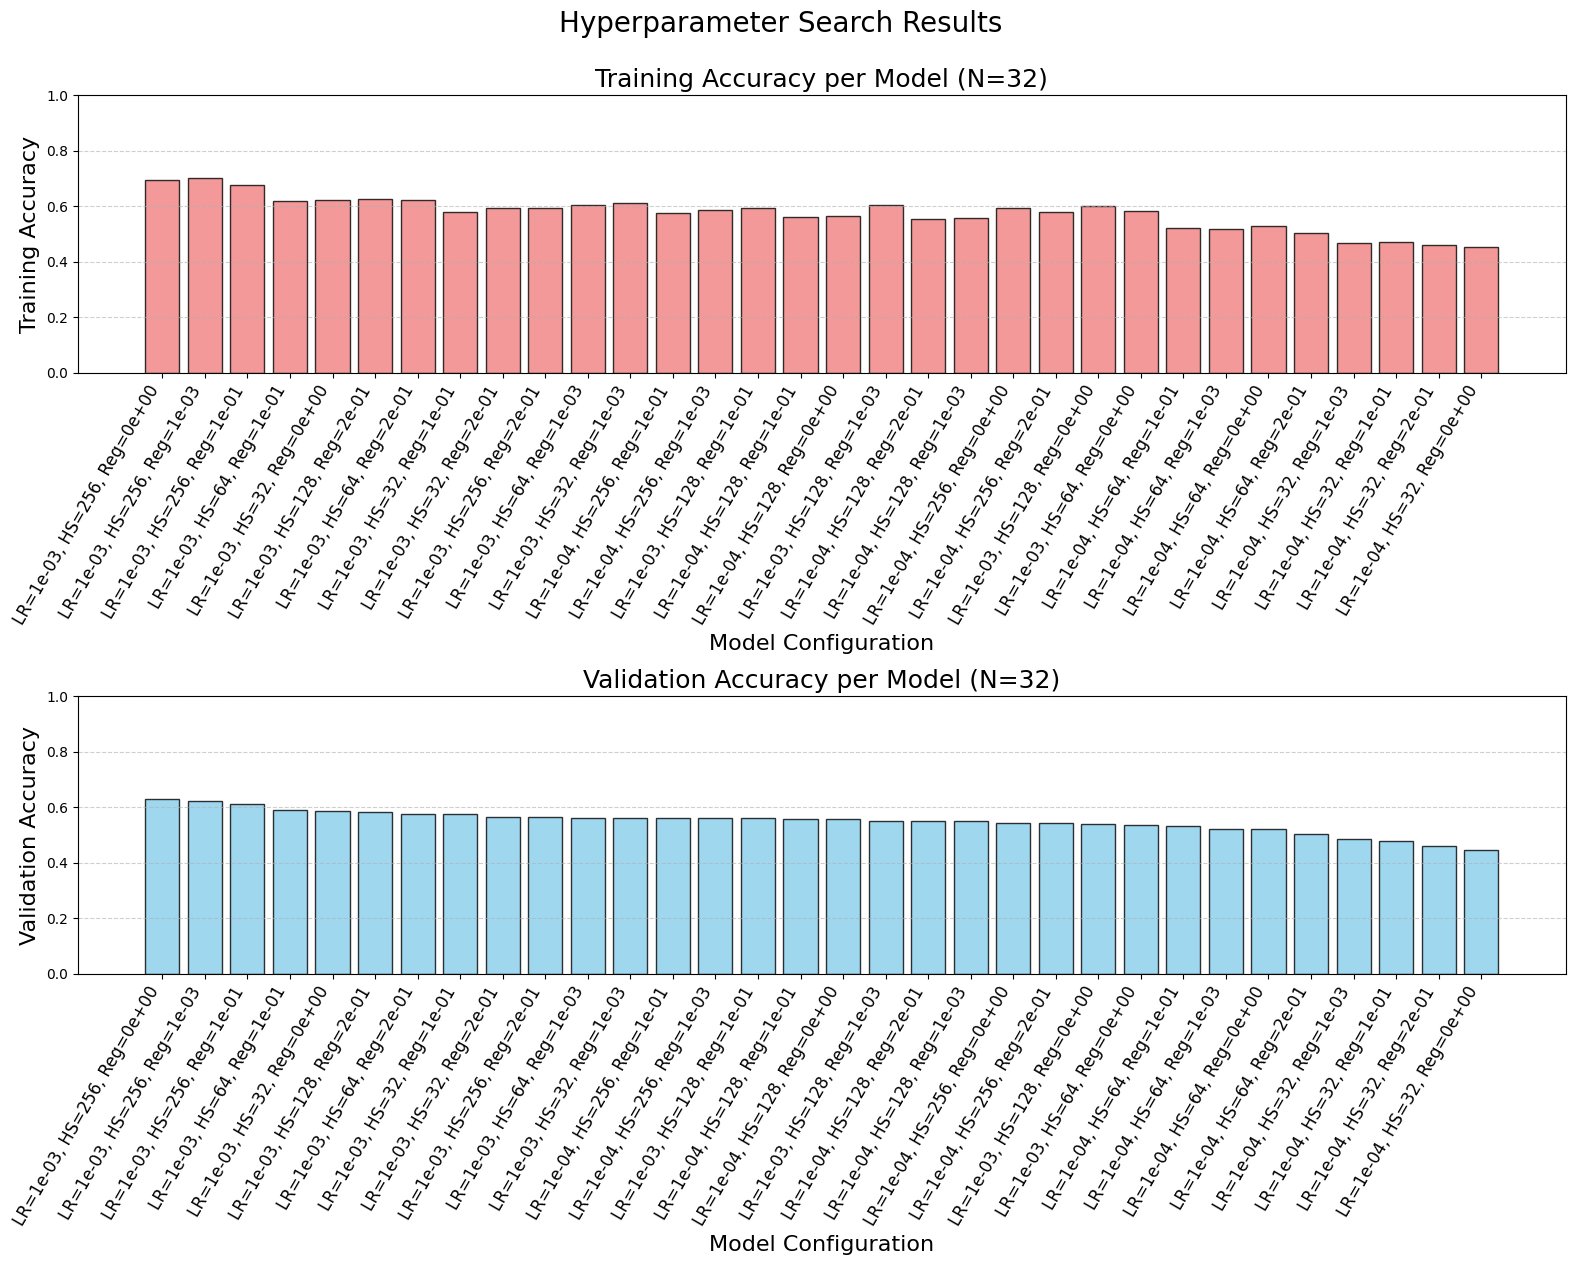

lr 1.000000e-04 hidden_size 32.000000 reg 0.000000 train accuracy: 0.454200 val accuracy: 0.445000
lr 1.000000e-04 hidden_size 32.000000 reg 0.001000 train accuracy: 0.469400 val accuracy: 0.487000
lr 1.000000e-04 hidden_size 32.000000 reg 0.100000 train accuracy: 0.472900 val accuracy: 0.478000
lr 1.000000e-04 hidden_size 32.000000 reg 0.250000 train accuracy: 0.462300 val accuracy: 0.462000
lr 1.000000e-04 hidden_size 64.000000 reg 0.000000 train accuracy: 0.528700 val accuracy: 0.520000
lr 1.000000e-04 hidden_size 64.000000 reg 0.001000 train accuracy: 0.519500 val accuracy: 0.522000
lr 1.000000e-04 hidden_size 64.000000 reg 0.100000 train accuracy: 0.523500 val accuracy: 0.533000
lr 1.000000e-04 hidden_size 64.000000 reg 0.250000 train accuracy: 0.505100 val accuracy: 0.502000
lr 1.000000e-04 hidden_size 128.000000 reg 0.000000 train accuracy: 0.563400 val accuracy: 0.558000
lr 1.000000e-04 hidden_size 128.000000 reg 0.001000 train accuracy: 0.557500 val accuracy: 0.550000
lr 1.000

In [ ]:
# This might take some time, try to expirement with small number of testing parameters before continuing
# You are encouraged to experiment with additional values
%%time
input_size = np.prod(X_train.shape[1:])
num_classes = len(np.unique(y_train))

learning_rates = [1e-4, 1e-3]
hidden_sizes = [32, 64, 128, 256]
regularizations = [0, 0.001, 0.1, 0.25]

results = {}
best_val = -1
best_net = None
################################################################################
#                            START OF YOUR CODE                                #
################################################################################
for lr in learning_rates:
  for hidden_size in hidden_sizes:
    for reg in regularizations:

      hp_key = (lr, hidden_size, reg)

      model = ThreeLayerNet(input_size, hidden_size, num_classes)

      stats = model.train(X_train, y_train, X_val, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=lr, reg=reg, verbose=False)

      val_acc = (model.predict(X_val) == y_val).mean()
      train_acc = (model.predict(X_train) == y_train).mean()

      perf_value = (train_acc, val_acc)

      results[hp_key] = perf_value

      if val_acc > best_val:
        best_val = val_acc
        best_net = model

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

hpo_histogram(results)

for lr, hidden_size, reg  in sorted(results):
    train_accuracy, val_accuracy = results[(lr, hidden_size, reg)]
    print ('lr %e hidden_size %f reg %f train accuracy: %f val accuracy: %f' % (
                lr, hidden_size, reg, train_accuracy, val_accuracy))

print ('best validation accuracy achieved during cross-validation: %f' % best_val)
print()
test_accuracy = (best_net.predict(X_test) == y_test).mean()
print ('Neural Network on raw pixels final test set accuracy: %f' % test_accuracy)

## Best setup 1


Run your best setup with 3 different seeds. Report mean±std for F1. Are results stable? If not, likely causes variance? (provid our answer + code)

**(3 Points)**


**Your answer:**

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

SEEDS = [1, 42, 21]
f1_scores = []
BEST_LR = 1e-3
BEST_REG = 1e-3
BEST_HS = 256
INPUT_SIZE  = np.prod(X_train.shape[1:])
NUM_CLASSES = len(np.unique(y_train))


for seed in SEEDS:

  np.random.seed(seed)

  best_net = ThreeLayerNet(np.prod(X_train.shape[1:]), BEST_HS, 3)
  best_net.train(X_train, y_train, X_val, y_val,BEST_LR, BEST_REG,
                 num_iters=1500, batch_size =200, verbose=False)

  y_pred = best_net.predict(X_test)
  f1_macro = f1_score(y_test, y_pred, average='macro')
  f1_scores.append(f1_macro)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print("\n--- Stability Results ---")
print(f"F1 Score (mean ± std): {mean_f1:.4f} ± {std_f1:.4f}")

if std_f1 <= 0.03:
  print("The the model is stable and robust \nit's able to consistently correctly classify the percentage of indepenedent testing instances, using the same model parameters")

else:
    print("The model isn't stable as it struggles to classify correctly across different seeds")


--- Stability Results ---
F1 Score (mean ± std): 0.5855 ± 0.0061
The the model is stable and robust 
it's able to consistently correctly classify the percentage of indepenedent testing instances, using the same model parameters


## Best setup 2

Run a learning curve for this homework by training on 10% / 30% / 50% / 100% of the training set (use 1 seed).

- Where does performance start to saturate?

- Does adding data help precision or recall more?

- Based on the curve’s shape, argue whether the current model is more bias-limited or variance-limited, and name one actionable change you’d try next.
- (provid our answer + code)

**(9 Points)**



Training on 10% of data (1000 samples)
Validation Accuracy: 0.4960, Precision: 0.5385, Recall: 0.5007
Training on 30% of data (3000 samples)
Validation Accuracy: 0.5800, Precision: 0.5817, Recall: 0.5819
Training on 50% of data (5000 samples)
Validation Accuracy: 0.5910, Precision: 0.6065, Recall: 0.5938
Training on 100% of data (10000 samples)
Validation Accuracy: 0.5820, Precision: 0.6227, Recall: 0.5816


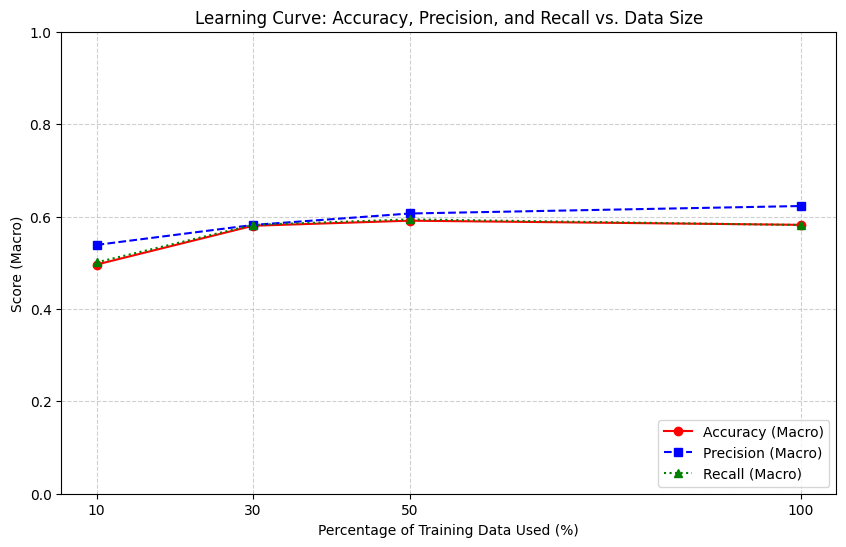

CPU times: user 6min 56s, sys: 1.77 s, total: 6min 57s
Wall time: 4min 10s


In [ ]:
%%time
from sklearn.metrics import precision_score, recall_score, accuracy_score
BEST_LR = 1e-3
BEST_REG = 1e-3
BEST_HS = 256
batch = 200
INPUT_SIZE  = np.prod(X_train.shape[1:])
NUM_CLASSES = len(np.unique(y_train))
num_epochs = 30

portions = [0.1, 0.3, 0.5, 1]
lc_results= {} # We'll store portion : (Val-acc, Prescision, Recall)
np.random.seed(42)

num_training_samples = X_train.shape[0]
all_indices = np.arange(num_training_samples)
np.random.shuffle(all_indices)

for p in portions:
  num_subset = int(num_training_samples*p)
  subset_indices = all_indices[:num_subset]
  X_subset = X_train[subset_indices]
  y_subset = y_train[subset_indices]

  print(f"Training on {p*100:.0f}% of data ({num_subset} samples)")

  np.random.seed(42)
  current_net = ThreeLayerNet(INPUT_SIZE, BEST_HS, NUM_CLASSES)

  num_iters = int(num_epochs * (num_subset / batch))

  current_net.train(
        X_subset, y_subset, X_val, y_val,
        BEST_LR,BEST_REG,
        num_iters, batch,
        verbose=False
    )

  y_pred_val = current_net.predict(X_val)
  val_acc = accuracy_score(y_val, y_pred_val)
  val_prec = precision_score(y_val, y_pred_val, average='macro', zero_division=0)
  val_rec = recall_score(y_val, y_pred_val, average='macro', zero_division=0)

  lc_results[p] = (val_acc, val_prec, val_rec)

  print(f"Validation Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}")


# --- EXTRACT DATA FOR PLOTTING ---
val_accuracies = [lc_results[p][0] for p in portions]
val_precisions = [lc_results[p][1] for p in portions]
val_recalls = [lc_results[p][2] for p in portions]

# --- Graph Plotting ---
plt.figure(figsize=(10, 6))
plt.plot([p * 100 for p in portions], val_accuracies, marker='o', linestyle='-', color='red', label='Accuracy (Macro)')
plt.plot([p * 100 for p in portions], val_precisions, marker='s', linestyle='--', color='blue', label='Precision (Macro)')
plt.plot([p * 100 for p in portions], val_recalls, marker='^', linestyle=':', color='green', label='Recall (Macro)')

plt.title('Learning Curve: Accuracy, Precision, and Recall vs. Data Size')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Score (Macro)')
plt.ylim(0, 1.0)
plt.xticks([10, 30, 50, 100])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()


1. $\text{Saturation starts to be observed when training on 30% and 50% onwards.}$ <br> $\text{The rate of measure (recall, accuracy, prescision) w.r.t. the percentage of training data used decreases. However, the prescision does seem to increase.}$

2. $\text{Adding more data helped improve accuracy, prescision and recall }$

3. $\text{Note that the model is more Bias-limited} \\ \text{Consider the change in the accuracy when using 50% of the data compared to 100% of the data,} \\ \text{we have < 1% change, indicating that with 50%, the model was near optimal.}$

4.  $\text{An actionalable solution could be to incrase the number of hidden layers, which could enable better approximations.}$

# Question

##**Question 1:**
Compare HW1 and HW2 along training time, performance, and tuning difficulty. Back claims with evidence.

- Training time

  Which modle took longer to train? Explain why one took longer (e.g., dataset size, model capacity, optimizer, I/O, augmentation).

- Performance

  Compare the main metric used in each HW (e.g., Accuracy/Macro-F1) on the validation set. which preduced better results and why?

- Tuning difficulty

  State which HW was harder to tune and why (search space size, instability, variance).

- One-line takeaway

  A single, precise sentence: “HW2 improved X by Y but cost Z (time/complexity), mainly due to …”

**(7 Points)**



$\text{Let } N \text{ be the Batch size} \\ \text{Let } D \text{ be the input dimension (features) } \\ \text{Let C be the output dimension (Classes)} \\ \text{Let } H_i \text{The Size of the Hidden layer } i$

| Comparing Point / <br> HW Number | HW1 | HW2 | EXPLANATION |
|----------------------------------|-----|-----|-------------|
| **$\text{Training Time}$** | $$\text{20.8s wall time}$$ | $$\text{1.2m wall time}$$ | $\text{Both models were trained on the same data type and with the same number of features.}$ <br> $\text{Therefore, the main cause for the difference in training time was the number of layers in the network.}$ <br> $\text{HW1 was a single-layer network with no hidden layer, thus the total number of computations was } O(NDC).$ <br> $\text{HW2 was a three-layer network, which required } O\!\left(N \cdot (D \cdot H_1 + H_1 \cdot H_2 + H_2 \cdot C)\right) \text{ computations.}$ |
| **$\text{Performance}$** | $\text{Validation accuracy: ~} 45\%$ | $\text{Validation accuracy: ~} 60\%$ | $\text{The performance improvement is due to higher model capacity in the three-layer architecture,} \\ \text{allowing better approximation of the input data space.}$ |
| **$\text{Tuning Difficulty}$** | $\text{The was fairly direct}$| $\text{The HPO Process was more complicated}$  | $\text{The Shallow network only required changing the Learning Rate and batch sizes} \\ \text{whereas in the 3-Layered-Network required also tuning the regularization levels}$|

## One-Line Conclusion:

$\text{The 3-layered network improved the accruacy by 15% but cost } O\!\left(N \cdot (D \cdot H_1 + H_1 \cdot H_2 + H_2 \cdot C)\right)$


##**Question 2:**

What can you say about the diffrence (or lack of thereof) between the validation and training accuracy?
**(3 Points)**

$\text{Our model on average produced the same accuracy for the training and validation.} \\ \text{When we near our optimal hyperparameters the difference between the training and validation accuracy became more evident.}$


## Question 3

What can you say about the connection between the loss and the accuracy? **(3 Points)**


**Your answer:**

$\text{One could say that there's at most an inverse correlation between the Accuracy and the Loss, however, this isn't a mathematical relation.}$

$\text{The loss is a continous distance measure between true value and predicted value, in our case was taken from the softmax.} \\ \text{The accuracy is a discrete measure of correctly classified instances (TN, TP) over the total instances.} \\ \text{Case 1: High Accuracy and Low Loss} \\ \\ \text{Case 2: High Loss and High Accuracy} \\ \text{Both cases are due to the confidence level of the predictions.}$

# The End